# Adding stochastic forces

In this example, we add a stochastic force to a planet. This can be used simulate migration in a turbulent disk. See e.g. [Rein (2010)](https://ui.adsabs.harvard.edu/abs/2010PhDT.......196R/abstract) and [Rein and Papaloizou (2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...497..595R/abstract). First, let's setup a REBOUND Simulation:

In [2]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.) # Star
sim.add(m=1e-3, a=1) # Jupiter mass planet
sim.move_to_com() 

sim.integrator = "whfast"
sim.dt = sim.particles[1].P/30.3

Note that we are using the WHFast integrator with a fixed timestep. It's important to point out that the IAS15 integrator is not well suited for stochastic forces because it automatically reduces the timestep if it doesn't achieve an accuracy near machine precision. Because the stochastic forces are random, it might never converge. 

Next, we add the `stochastic_forces` module in REBOUNDx

In [3]:
import reboundx
rebx = reboundx.Extras(sim)
sto = rebx.load_force("stochastic_forces")
rebx.add_force(sto)

We can now turn on stochastic forces for a particle by setting the field `kappa` to a finite value. This parameter determines the strength of the stochastic forces and is relative to the gravitational force that the particle experiences from the center of mass. 

In [4]:
sim.particles[1].params["kappa"] = 1.0e-5

In [5]:
import numpy as np
times = np.linspace(0.,1e4*np.pi*2., 1000)
semia = np.zeros(len(times))
for i, t in enumerate(times):
    sim.integrate(t)
    semia[i] = sim.particles[1].a

Let's check if the semi-major axis is changing.

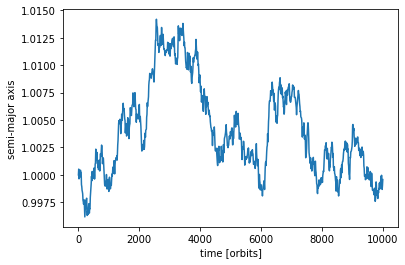

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [orbits]")
ax.set_ylabel("semi-major axis")
ax.plot(times/np.pi/2., semia);

Let us run a few more simulations with different diffusion parameters and verify that the planet is indeed undergoing a random walk where the semi-major axes grow as $\Delta a \sim \sqrt{t}$. 

In [7]:
def runsim(kappa):
    sim = rebound.Simulation()
    sim.add(m=1.) # Star
    sim.add(m=1e-3, a=1) # Jupiter mass planet
    sim.move_to_com() 

    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/30.3
    
    rebx = reboundx.Extras(sim)
    sto = rebx.load_force("stochastic_forces")
    rebx.add_force(sto)
    
    sim.particles[1].params["kappa"] = kappa
    
    times = np.pi*2.*np.logspace(0.,5, 1000)
    semia = np.zeros(len(times))
    for i, t in enumerate(times):
        sim.integrate(t)
        semia[i] = sim.particles[1].a
    return times, semia

In [9]:
kappas = [1e-6, 1e-5, 1e-4]
results = np.zeros((len(kappas),1000))
for i, kappa in enumerate(kappas):
    times, results[i] = runsim(kappa)

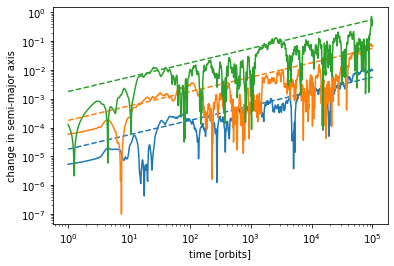

In [11]:
fig, ax = plt.subplots(1,1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("time [orbits]")
ax.set_ylabel("change in semi-major axis")
for i, kappa in enumerate(kappas):
    p = ax.plot(times/np.pi/2., np.abs(1.-results[i]))
    tau = 2.*np.pi
    D = 2.*kappa**2*tau
    ax.plot(times/np.pi/2., np.sqrt(4.*D/sim.particles[1].n**2*times), color=p[0].get_color(), ls="--") 